# Machine Learning - Report 2

The purpose of this report is to train algorithms to perform facial recognition on a given dataset. In contrast to the previous report which utilized supervised learning techniques, this report will focus on unsupervized learning.

As with the first report, the `seaborn` library will be used for plotting and `scikit-learn-intelex` will be used to optimize `scikit-learn` to run on Intel architecture.

In [78]:
import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_theme(); sns.set_palette('deep'); sns.set_palette([sns.color_palette()[i] for i in [0,1,2,3,4,7,9]])
sns.color_palette("Paired")
plt.rc('legend', fontsize=8); plt.rc('xtick', labelsize=9); plt.rc('ytick', labelsize=9); plt.rc('axes', labelsize=10), plt.rc('axes', titlesize=12)

from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Preliminary Evaluation of the Dataset

We observe that the dataset contains 64x64 pixel pictures of 40 different people, 10 pictures per person. 

The pictures are each labeled with a number corresponding to the person they belong to, note that since we will be performing unsupervised learning, the labels are only for us to qualitatively assess the performance of the trained algorithms, they are not used in the training of the models.

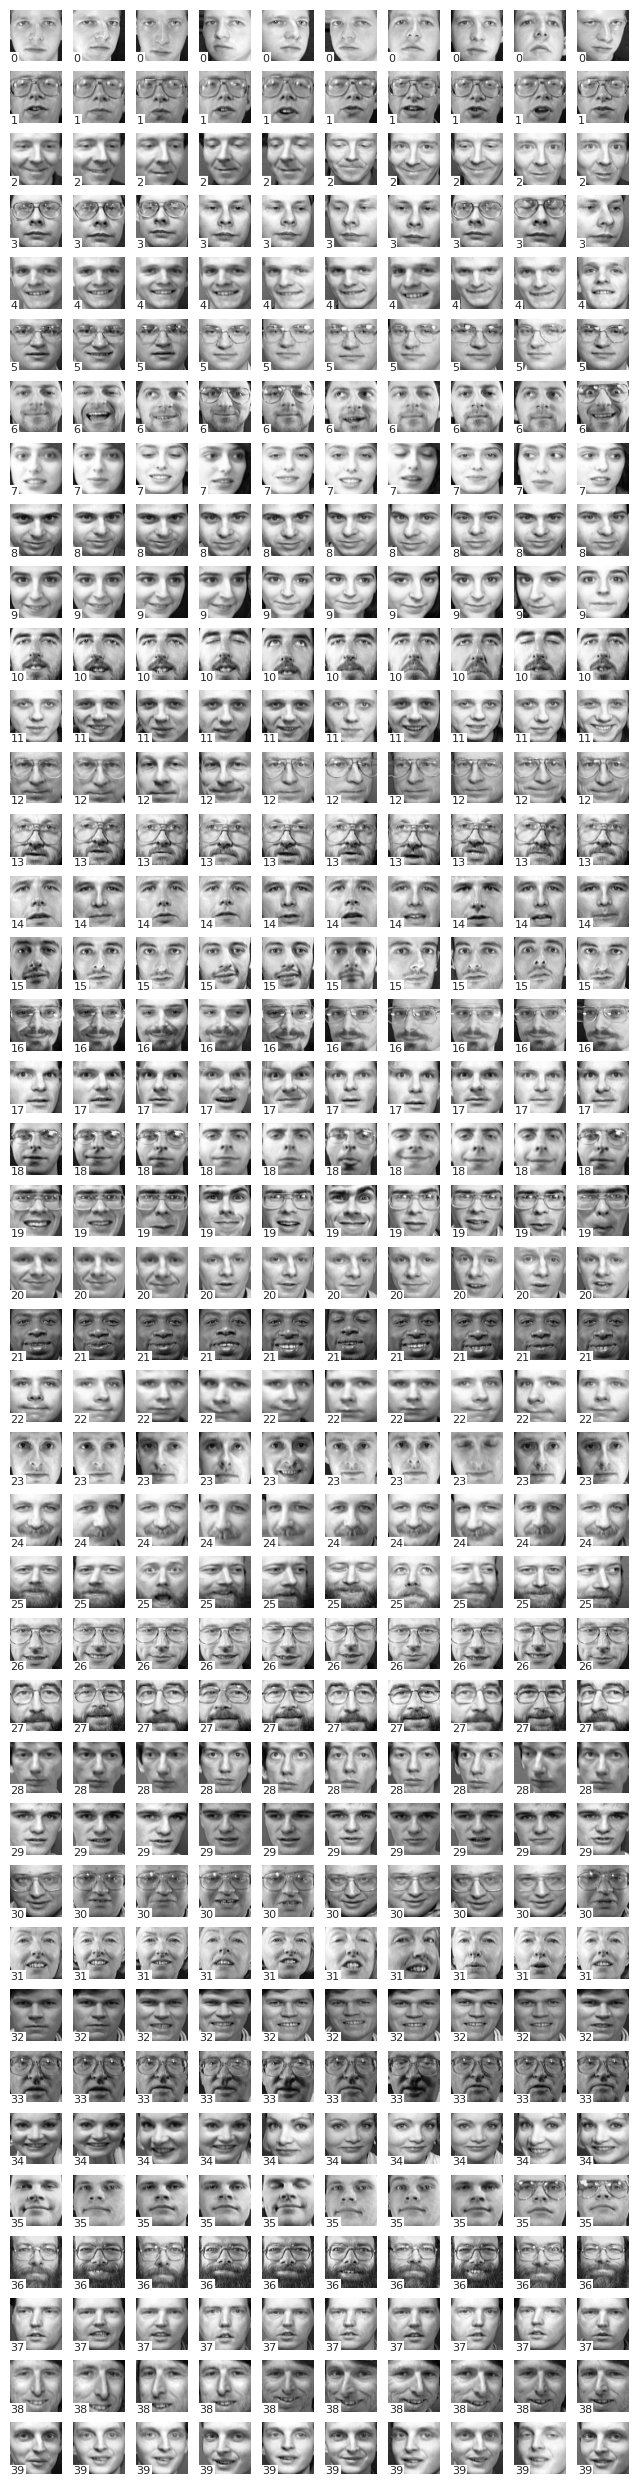

In [79]:
with open('Datasets/faces_dict.p', 'rb') as f:
    data = pkl.load(f)

plt.rcParams["figure.figsize"] = (10*0.8,40*0.8)
fig, axs = plt.subplots(40, 10)
for t in set(data['target']):
    k=0
    for i in data['images'][data['target']==int(t)]:
        axs[t,k].imshow(i, cmap='gray')
        axs[t,k].axis("off")
        axs[t,k].text(0, 64, str(t), fontsize=8, bbox=dict(boxstyle="square,pad=0.1", fc="w", lw=0.1))
        k+=1

The dataset will be partitioned into a training set and a testing set, assigning 40 samples to the testing set. 

The split will be stratified in order to ensure that the testing set will consist of one picture of each target, the remaining 9 being used for training. 

In [80]:
from sklearn.model_selection import StratifiedShuffleSplit

strat_split = StratifiedShuffleSplit(n_splits=1, test_size=40)
train_idx, test_idx = next(strat_split.split(data['data'], data['target']))
X_train = data['data'][train_idx]
y_train = data['target'][train_idx]
X_test  = data['data'][test_idx]
y_test  = data['target'][test_idx]

X_train = [np.array(x) for x in X_train]
X_test  = [np.array(x) for x in X_test]

## Dimensionality Reduction

In order to facilitate finding meaningful clusters in the dataset and to speed up the training of the algorithms, dimensionality reduction will be used. The reduction will be done with Principal Component Analysis. 

In [81]:
from sklearn.decomposition import PCA

pca = PCA(0.9)
X_train_pca = pca.fit_transform(X_train)
X_test_pca  = pca.transform(X_test)

print(f"Original dataset: {len(X_train[1])} dimensions\n Reduced dataset: {len(X_train_pca[1])} dimensions")

Original dataset: 4096 dimensions
 Reduced dataset: 64 dimensions


## K-means Clustering

The first unsupervised training algorithm we will observe is K-means clustering. 

In its simplest form, K-means clustering can be trained by reducing the dimensionality of the dataset all the way to 2 dimensions and partitioning the resulting feature space into $K$ regions, with $K$ equal to the number of classes in the dataset, in this case 40.

In [82]:
from sklearn.cluster import KMeans

pca = PCA(n_components=2)
X_train_pca_2 = pca.fit_transform(X_train)
X_test_pca_2  = pca.transform(X_test)

kmeans = KMeans(n_clusters=40).fit(X_train_pca_2)

The only advantage of reducing the dimensionality of the problem to two dimenisons is that it makes it possible to visualize the partitioned reduced feature space and develop an intuition on how the algorithm will operate when extended to higher dimensions.

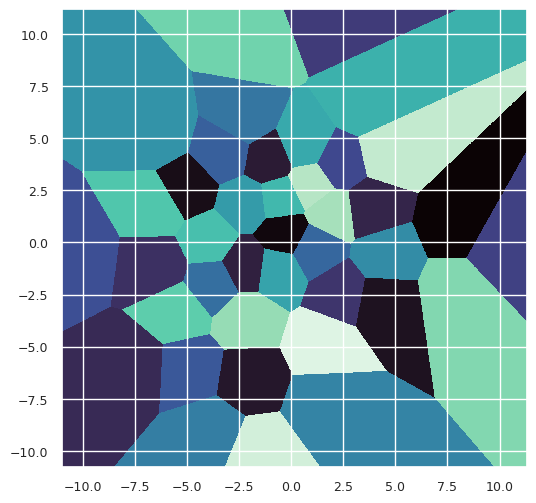

In [83]:
plt.rcParams["figure.figsize"] = (6,6)
h=0.01
x_min, x_max = X_train_pca_2[:,0].min(), X_train_pca_2[:,0].max()
y_min, y_max = X_train_pca_2[:,1].min(), X_train_pca_2[:,1].max()
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.imshow(Z, interpolation="nearest", extent=(xx.min(), xx.max(), yy.min(), yy.max()), cmap=sns.color_palette("mako", as_cmap=True))

We can now scatter the testing set onto the partitioned feature space to qualitatively observe the performance of the algorithm.

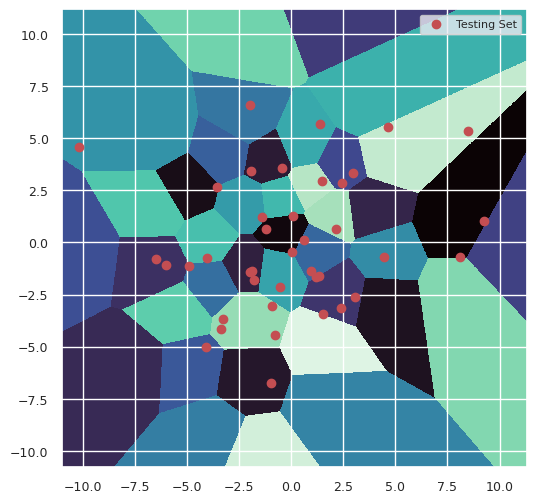

In [84]:
plt.imshow(Z, interpolation="nearest", extent=(xx.min(), xx.max(), yy.min(), yy.max()), cmap=sns.color_palette("mako", as_cmap=True))
plt.scatter(X_test_pca_2[:,0], X_test_pca_2[:,1], color='r', label="Testing Set")
plt.legend()

Needless to say, the performance of the algorithm is terrible when reduced to only two dimensions, with several samples of the training set falling into the same cluster which should not happen under a stratified train-test split of the dataset. 

Having visualized how the K-means algorithm will operate, we will apply it to a more useful dimensionality.

### Hyperparameter Tuning

There are actually two hyperparameters that we can tune in our problem, one is the number of means $K$ that will be used to partition the feature space, the other is the number of components $N$ that the feature space will be reduced into.

For practicality, we will keep $N$ at 241 components and only tune the $K$ hyperparameter, but it is good to keep in mind that $N$ can also be tuned.

The absolute minimum value that $K$ can take is the number of classes in the dataset, in this case 40, however a higher number is reasonable since the same target can form more than one cluster in the target space (for example, one cluster of pictures looking to the left and another cluster of pictures looking to the right).

The maximum value that $K$ can reasonably take is the number of samples that there are the training, but this would be a case of terrible overfitting. We'll sweep the value of $K$ from the minimum of 40 to a more reasonable maximum of 180.

In [85]:
from sklearn.cluster import KMeans

k_range = range(40, 180, 5)
kmeans_per_k = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_train_pca)
    kmeans_per_k.append(kmeans)

The silhouette score will be used to determine the best $K$.

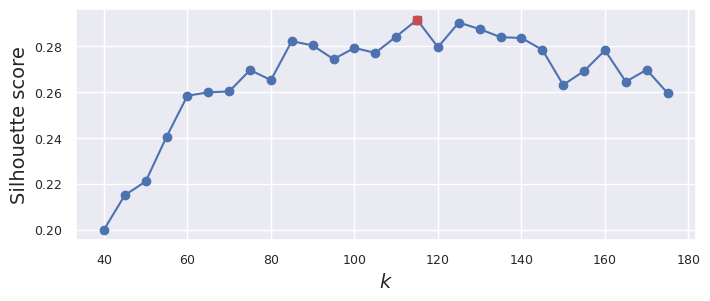

In [86]:
from sklearn.metrics import silhouette_score

silhouette_scores = [silhouette_score(X_train_pca, model.labels_)
                     for model in kmeans_per_k]
best_index = np.argmax(silhouette_scores)
best_k = k_range[best_index]
best_score = silhouette_scores[best_index]
kmeans = kmeans_per_k[best_index]

plt.figure(figsize=(8, 3))
plt.plot(k_range, silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.plot(best_k, best_score, "rs")
plt.show()

Having chosen the best $K$, we will qualitatively assess the performance of the algorithm by classifying the testing set into the various clusters.

We will plot the individual faces in the testing set on the left hand column, and the cluster it was classified into on the right hand column, each face properly labeled.

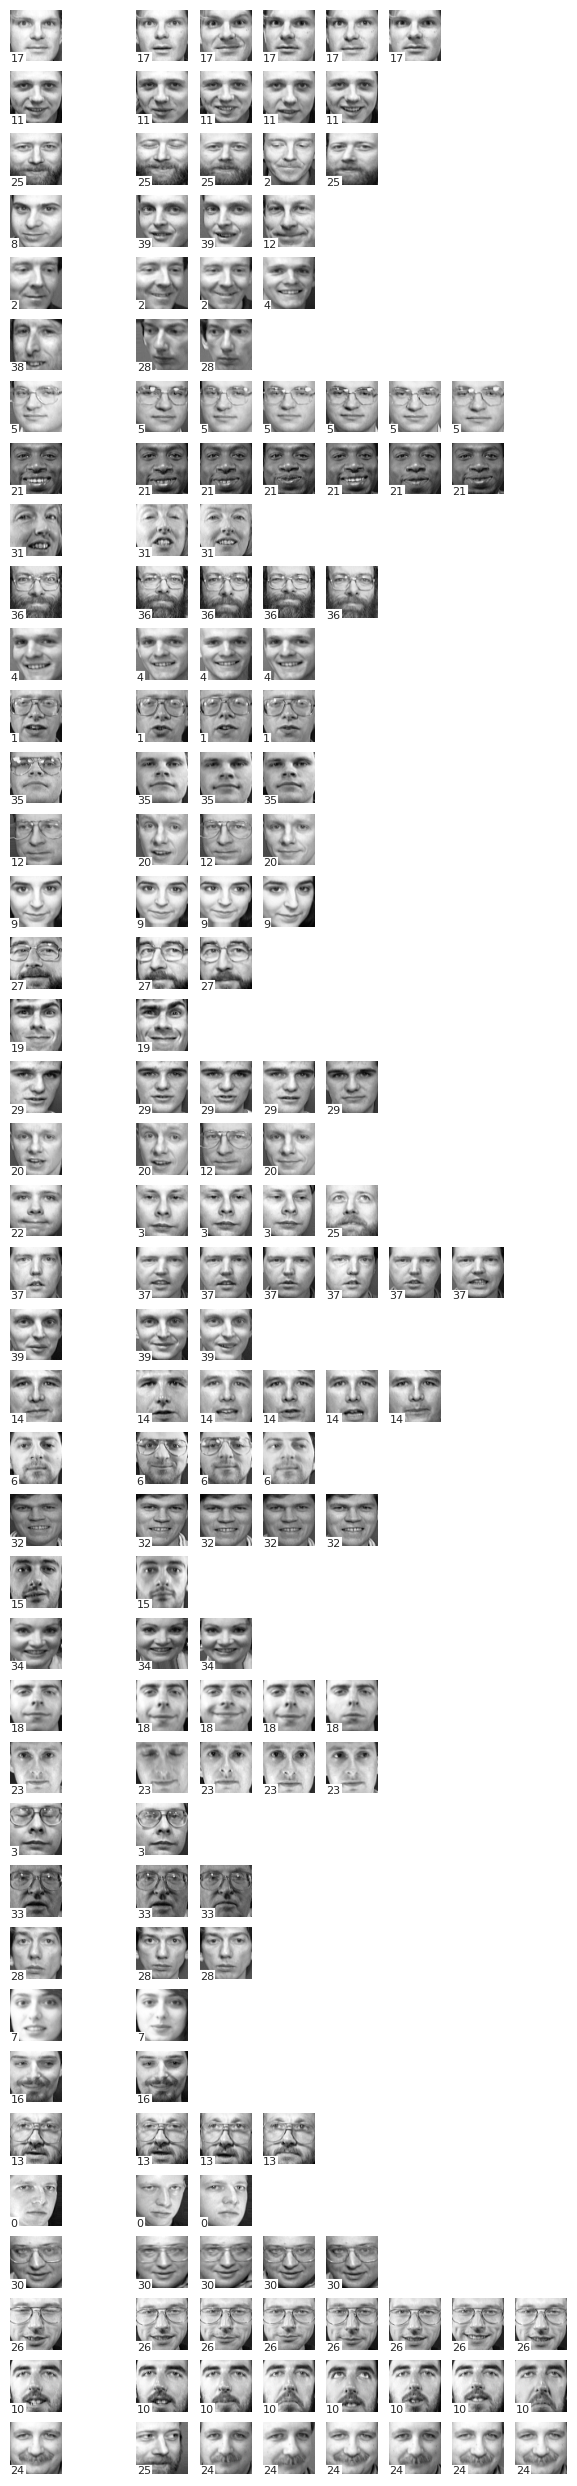

In [87]:
maxsize = max([sum(kmeans.labels_==c) for c in kmeans.predict(X_test_pca)])

plt.rcParams["figure.figsize"] = (0.8*(maxsize+2),0.8*40)
fig, axs = plt.subplots(40, maxsize+2)
for ax in axs:
    for a in ax:
        a.axis("off")
k=0
for test_face, test_target, cluster_id in zip(X_test, y_test, kmeans.predict(X_test_pca)):
    axs[k,0].imshow(test_face.reshape(64,64), cmap='gray')
    axs[k,0].text(0, 64, str(test_target), fontsize=8, bbox=dict(boxstyle="square,pad=0.1", fc="w", lw=0.1))
    in_cluster = kmeans.labels_==cluster_id 
    i=2
    for face, label in zip(np.array(X_train)[in_cluster], y_train[in_cluster]):
        axs[k,i].imshow(face.reshape(64,64), cmap='gray')
        axs[k,i].text(0, 64, str(label), fontsize=8, bbox=dict(boxstyle="square,pad=0.1", fc="w", lw=0.1))
        i+=1
    k+=1